# Movielens 영화 추천 실습
- 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로있다.
- 별점 데이터는 대표적인 ```Explicit```데이터, 하지만 ```implicit```데이터로 간주하고 테스트해볼 수 있다..
- 별점을 **시청횟수**로 해석해서 생각
- 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외

# 코드

## 1) 라이브러리 import 및 데이터 가져오기

In [1]:
import os
import re
import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

Movielens 데이터는 ```rating.dat``` 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있다.

In [2]:
rating_file_path=os.getenv('HOME') + '/aiffel/recommenddata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python')
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
# 3점 이상만
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [4]:
# rating 컬럼의 이름을 count로 바꿉니다.
ratings.rename(columns={'rating':'count'}, inplace=True)

In [5]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommenddata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# 영화의 제목에서 개봉년도를 제거
pattern = re.compile('[^a-zA-Z]*$')
movies['title'] = movies['title'].map(lambda x : pattern.sub('', x))
movies

,movie_id,title,genre
0,1,Toy Story,Animation|Children's|Comedy
1,2,Jumanji,Adventure|Children's|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama
4,5,Father of the Bride Part II,Comedy
...,...,...,...
3878,3948,Meet the Parents,Comedy
3879,3949,Requiem for a Dream,Drama
3880,3950,Tigerland,Drama
3881,3951,Two Family House,Drama


In [7]:
# 영화 제목들을 소문자로 변환
movies['title'] = movies['title'].str.lower()
movies

,movie_id,title,genre
0,1,toy story,Animation|Children's|Comedy
1,2,jumanji,Adventure|Children's|Fantasy
2,3,grumpier old men,Comedy|Romance
3,4,waiting to exhale,Comedy|Drama
4,5,father of the bride part ii,Comedy
...,...,...,...
3878,3948,meet the parents,Comedy
3879,3949,requiem for a dream,Drama
3880,3950,tigerland,Drama
3881,3951,two family house,Drama


In [8]:
# ratings와 영화의 제목들 join해준다.
ratings_with_title = pd.merge(ratings, movies[['title', 'movie_id']], on='movie_id', how='left')
ratings_with_title

,user_id,movie_id,count,timestamp,title
0,1,1193,5,978300760,one flew over the cuckoo's nest
1,1,661,3,978302109,james and the giant peach
2,1,914,3,978301968,my fair lady
3,1,3408,4,978300275,erin brockovich
4,1,2355,5,978824291,"bug's life, a"
...,...,...,...,...,...
836473,6040,1090,3,956715518,platoon
836474,6040,1094,5,956704887,"crying game, the"
836475,6040,562,5,956704746,welcome to the dollhouse
836476,6040,1096,4,956715648,sophie's choice


## 2) 분석
- ratings에 있는 유니크한 영화 개수
- rating에 있는 유니크한 사용자 수
- 가장 인기있는 영화 30개 인기순

In [9]:
ratings

,user_id,movie_id,count,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [10]:
# 유니크한 영화 개수
ratings['movie_id'].nunique()

3628

In [11]:
# 유니크한 사용자 수
ratings['user_id'].nunique()

6039

In [12]:
# 가장 인기있는 영화 30개
# movie_count = ratings.groupby('movie_id')['movie_id'].count()
# movie_count.sort_values(ascending=False).head(30)
ratings['movie_id'].value_counts().head(30)

2858    3211
260     2910
1196    2885
1210    2716
2028    2561
589     2509
593     2498
1198    2473
1270    2460
2571    2434
480     2413
2762    2385
608     2371
110     2314
1580    2297
527     2257
1197    2252
2396    2213
1617    2210
318     2194
858     2167
1265    2121
1097    2102
2997    2066
2716    2051
296     2030
356     2022
1240    2019
1       2000
457     1941
Name: movie_id, dtype: int64

## 3) 내가 선호하는 영화 5가지를 골라서 rating 에 추가

In [13]:
# 5개의 영화를 소문자로 변경
my_favorite = ['E.T. the Extra-Terrestrial', 'star wars: episode iv - a new hope', 'Jaws', 'Saving Private Ryan', 'Poltergeist']
my_favorite= list(map(lambda x : x.lower(), my_favorite))
my_favorite

my_playlist = pd.DataFrame({'user_id':['jaeho']*5, 'title':my_favorite, 'count':[5]*5})

if not ratings_with_title.isin({'user_id':['jaeho']})['user_id'].any():
    ratings_with_title = ratings_with_title.append(my_playlist)
    
ratings_with_title.tail(10)

,user_id,movie_id,count,timestamp,title
836473,6040,1090.0,3,956715518.0,platoon
836474,6040,1094.0,5,956704887.0,"crying game, the"
836475,6040,562.0,5,956704746.0,welcome to the dollhouse
836476,6040,1096.0,4,956715648.0,sophie's choice
836477,6040,1097.0,4,956715569.0,e.t. the extra-terrestrial
0,jaeho,NaN,5,NaN,e.t. the extra-terrestrial
1,jaeho,NaN,5,NaN,star wars: episode iv - a new hope
2,jaeho,NaN,5,NaN,jaws
3,jaeho,NaN,5,NaN,saving private ryan
4,jaeho,NaN,5,NaN,poltergeist


In [14]:
# timestamp 컬럼 제거
ratings_with_title.drop('timestamp', axis=1, inplace=True)

In [15]:
# index리셋
ratings_with_title.reset_index(drop=True, inplace=True)

In [16]:
# 수정후 데이터 확인
ratings_with_title.tail(10)

,user_id,movie_id,count,title
836473,6040,1090.0,3,platoon
836474,6040,1094.0,5,"crying game, the"
836475,6040,562.0,5,welcome to the dollhouse
836476,6040,1096.0,4,sophie's choice
836477,6040,1097.0,4,e.t. the extra-terrestrial
836478,jaeho,NaN,5,e.t. the extra-terrestrial
836479,jaeho,NaN,5,star wars: episode iv - a new hope
836480,jaeho,NaN,5,jaws
836481,jaeho,NaN,5,saving private ryan
836482,jaeho,NaN,5,poltergeist


In [17]:
title2id = dict(zip(movies['title'], movies['movie_id']))
title2id

{'toy story': 3114,
 'jumanji': 2,
 'grumpier old men': 3,
 'waiting to exhale': 4,
 'father of the bride part ii': 5,
 'heat': 6,
 'sabrina': 915,
 'tom and huck': 8,
 'sudden death': 9,
 'goldeneye': 10,
 'american president, the': 11,
 'dracula: dead and loving it': 12,
 'balto': 13,
 'nixon': 14,
 'cutthroat island': 15,
 'casino': 16,
 'sense and sensibility': 17,
 'four rooms': 18,
 'ace ventura: when nature calls': 19,
 'money train': 20,
 'get shorty': 21,
 'copycat': 22,
 'assassins': 23,
 'powder': 24,
 'leaving las vegas': 25,
 'othello': 2848,
 'now and then': 27,
 'persuasion': 28,
 'city of lost children, the': 29,
 'shanghai triad (yao a yao yao dao waipo qiao': 30,
 'dangerous minds': 31,
 'twelve monkeys': 32,
 'wings of courage': 33,
 'babe': 34,
 'carrington': 35,
 'dead man walking': 36,
 'across the sea of time': 37,
 'it takes two': 38,
 'clueless': 39,
 'cry, the beloved country': 40,
 'richard iii': 41,
 'dead presidents': 42,
 'restoration': 43,
 'mortal kombat

In [18]:
# 추가한 5개의 영화에 대해서 movie_id를
# 위에서 만든 title2id 딕셔너리를 사용해서 채워준다.
for idx in range(836478, 836483) :
    m_idx = title2id[ratings_with_title.loc[idx]['title']]
    ratings_with_title.loc[idx] = ratings_with_title.loc[idx].fillna(m_idx)

ratings_with_title.tail(10)

,user_id,movie_id,count,title
836473,6040,1090.0,3,platoon
836474,6040,1094.0,5,"crying game, the"
836475,6040,562.0,5,welcome to the dollhouse
836476,6040,1096.0,4,sophie's choice
836477,6040,1097.0,4,e.t. the extra-terrestrial
836478,jaeho,1097.0,5,e.t. the extra-terrestrial
836479,jaeho,260.0,5,star wars: episode iv - a new hope
836480,jaeho,1388.0,5,jaws
836481,jaeho,2028.0,5,saving private ryan
836482,jaeho,1994.0,5,poltergeist


## 4) CSR Matrix 만들기

In [19]:
# 고유한 유저, 영화명을 찾아내는 코드
user_unique = ratings_with_title['user_id'].unique()
movie_unique = ratings_with_title['title'].unique()

# 유저, 영화 indexing하는 코드 idx는 index의 약자
user_to_idx = {v:k for k, v in enumerate(user_unique)}
movie_to_idx = {v:k for k, v in enumerate(movie_unique)}

In [20]:
print(user_to_idx['jaeho'])
print(movie_to_idx['jaws'])

6039
195


In [21]:
# indexing을 통해 데이터 칼럼 내 값을 바꾸는 코드
# dictionary 자료형의 get함수는 뭐를 참고하시구

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 본다.
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될테니 dropna()로 제거한다.
temp_user_data = ratings_with_title['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(ratings_with_title):  # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id done')
    ratings_with_title['user_id'] = temp_user_data
else :
    print('user_id fail')
    
temp_movie_data = ratings_with_title['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(ratings_with_title) :
    print('movie done')
    ratings_with_title['title'] = temp_movie_data
else :
    print('movie fail')
    
ratings_with_title

user_id done
movie done


,user_id,movie_id,count,title
0,0,1193.0,5,0
1,0,661.0,3,1
2,0,914.0,3,2
3,0,3408.0,4,3
4,0,2355.0,5,4
...,...,...,...,...
836478,6039,1097.0,5,26
836479,6039,260.0,5,44
836480,6039,1388.0,5,195
836481,6039,2028.0,5,48


In [23]:
# movie_id의 type을 int형으로 변경
ratings_with_title['movie_id'] = ratings_with_title['movie_id'].astype(np.int64)
ratings_with_title

,user_id,movie_id,count,title
0,0,1193,5,0
1,0,661,3,1
2,0,914,3,2
3,0,3408,4,3
4,0,2355,5,4
...,...,...,...,...
836478,6039,1097,5,26
836479,6039,260,5,44
836480,6039,1388,5,195
836481,6039,2028,5,48


In [24]:
# dtype 확인
ratings_with_title.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836483 entries, 0 to 836482
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   836483 non-null  int64
 1   movie_id  836483 non-null  int64
 2   count     836483 non-null  int64
 3   title     836483 non-null  int64
dtypes: int64(4)
memory usage: 25.5 MB


In [25]:
# csr_matrix 생성
num_user = ratings_with_title['user_id'].nunique()
num_movie = ratings_with_title['title'].nunique()

csr_data = csr_matrix((ratings_with_title['count'].values, (ratings_with_title['user_id'].values, ratings_with_title['title'].values)) , shape= (num_user, num_movie))
csr_data

<6040x3548 sparse matrix of type '<class 'numpy.int64'>'
	with 827567 stored elements in Compressed Sparse Row format>

In [49]:
num_user, num_movie

(6040, 3548)

## 5) als_model = AlternatingLeastSquares 모델 구성 및 훈련

In [28]:
# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [29]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [30]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3548x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 827567 stored elements in Compressed Sparse Column format>

In [31]:
# 모델 훈련
als_model.fit(csr_data_transpose)

## 6) 훈련된 모델이 예측한 나의 선호도 파악 

### 6-1) 나의 벡터와 "죠스"영화의 선호도 구하기 : ```0.577```
- 사용자의 성향과 영화의 성향이 잘 맞는가?
- 수치상으로 보면 나쁘지 않게 나온 것으로 보인다.
    - 사용자의 벡터와 영화의 벡터를 내적으로 곱하게 되면 두 벡터간의 유사성을 구하게 된다. 1에 가까울수록 잘 맞는 것이고 0에 가까울 수록 맞지 않는 것이다.
- 그렇다면 이 스코어를 100프로 믿어도 되는가?
    - 정답은 검증되지 않았다이다. 학습 데이터에 대해서 fitting은 되었지만 아직 보지 못한 데이터에 대해서는 사용자가 선호할 것인가라는 예측은 잘할지 못할지 검증을 하지 않았기 때문에 정확한 수치는 아니다.

In [43]:
# 나의 벡터와 'jaws'영화 벡터 구하기
jaeho, jaws = user_to_idx['jaeho'], movie_to_idx['jaws']
jaeho_vector, jaws_vector = als_model.user_factors[jaeho], als_model.item_factors[jaws]

In [44]:
jaeho_vector

array([-0.70446104, -1.2262527 ,  1.0939662 ,  0.22185445, -0.35842064,
       -0.4753478 ,  0.5953026 ,  0.7214242 ,  0.6665811 ,  0.44494838,
        0.5754479 , -0.04104294,  0.43908736,  0.12002494,  0.147054  ,
       -0.8172061 ,  0.3675324 , -0.724965  , -0.10740662,  0.40078235,
       -0.783509  , -0.49679342, -0.30124637,  0.32801446,  0.85755295,
        0.17637172, -0.5291392 ,  0.98753256, -0.2651011 , -1.0171793 ,
       -0.6571565 , -0.95541704,  0.53454316, -0.82931304,  0.38172713,
        0.43547264,  0.4127024 , -0.28320083,  0.39568973,  0.79732627,
        0.44281432,  0.51209295, -0.2390758 , -0.93255633,  0.5241396 ,
       -0.27219716,  0.04439412, -0.78483975, -0.23926668, -0.6102607 ,
        0.0078383 , -0.65327895,  0.5450436 , -0.0854962 , -0.7066663 ,
       -1.0054759 ,  0.83333045, -0.56810427,  0.8316759 ,  0.05526655,
        0.10647734,  0.15980569, -0.39944646,  0.06124435, -0.196837  ,
        0.20804025,  1.175255  ,  0.3841015 ,  1.1555675 , -0.03

In [45]:
jaws_vector

array([-0.01254324, -0.01316876,  0.02824573,  0.01734398, -0.01813289,
       -0.02620685,  0.02247122,  0.01992806,  0.03731887,  0.00469615,
        0.02243078, -0.00506903,  0.0046599 ,  0.00799007,  0.01314771,
       -0.00481528,  0.03073025,  0.01214198,  0.02617307,  0.03430133,
       -0.00443854, -0.0141662 ,  0.01740098, -0.00397379,  0.01143006,
       -0.00640125, -0.00876416,  0.02610646,  0.01838016, -0.03607294,
       -0.02581664, -0.02600201,  0.00022384,  0.01554071,  0.00802747,
        0.00364887,  0.01650966, -0.00527774,  0.02192475,  0.01426858,
        0.01096413,  0.02030776, -0.00610711, -0.00701466,  0.03810667,
       -0.00462035,  0.00403873, -0.0171748 ,  0.02810951, -0.01089476,
       -0.02104212, -0.01448469,  0.00645001, -0.01030831, -0.01878668,
       -0.01796485,  0.0084242 ,  0.00457775,  0.03695133,  0.0138583 ,
        0.00196758, -0.02676886,  0.00141199,  0.03299533,  0.01876738,
       -0.01007428,  0.03373458, -0.00837069,  0.01673214, -0.00

In [46]:
np.dot(jaeho_vector, jaws_vector)

0.5770185

### 6-2) '라이언 일병 구하기'영화에 대해서 선호도 예측

In [36]:
ryan = movie_to_idx['saving private ryan']
ryan_vector = als_model.item_factors[ryan]
np.dot(jaeho_vector, ryan_vector)

0.56053054

## 7) 포켓몬 영화로 비슷한 영화 추천받기
- 비슷한 애니메이션 위주의 영화들이 나왔다.

In [37]:
favorite_movie = 'pok�mon: the first movie'
movie_id = movie_to_idx[favorite_movie]
similar_movie = als_model.similar_items(movie_id, N=15)
similar_movie

[(1945, 0.053072132),
 (1944, 0.041780885),
 (1953, 0.03975518),
 (1960, 0.039033987),
 (1523, 0.03879774),
 (1971, 0.03831371),
 (2937, 0.03689294),
 (2130, 0.0367971),
 (934, 0.036466323),
 (1963, 0.036159337),
 (1975, 0.03614354),
 (925, 0.036088258),
 (3073, 0.034895774),
 (385, 0.034894735),
 (2031, 0.034691982)]

In [38]:
# movie_to_idx 를 뒤집어, index로부터 movie 이름을 얻는 dict를 생성합니다. 
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in similar_movie]

['pok�mon: the first movie',
 'return of jafar, the',
 "we're back! a dinosaur's story",
 'goofy movie, a',
 'aladdin and the king of thieves',
 'pagemaster, the',
 'quest for camelot',
 'thumbelina',
 'rescuers down under, the',
 'mighty morphin power rangers: the movie',
 'oliver & company',
 'american tail: fievel goes west, an',
 'land before time iii: the time of the great giving',
 'batman: mask of the phantasm',
 'great mouse detective, the']

In [39]:
def get_similar_artist(movie_name: str):
    movie_id = movie_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

print("슝=3")

슝=3


## 8) 사용자에게 영화 추천

In [40]:
user = user_to_idx['jaeho']
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(119, 0.50282514),
 (116, 0.48926383),
 (192, 0.39911854),
 (63, 0.37831363),
 (22, 0.36547416),
 (976, 0.33218136),
 (59, 0.30295628),
 (23, 0.29340202),
 (372, 0.27974254),
 (819, 0.27890766),
 (86, 0.275338),
 (90, 0.25906223),
 (314, 0.25543508),
 (198, 0.22948778),
 (120, 0.22763267),
 (883, 0.22343786),
 (41, 0.21352445),
 (171, 0.20786856),
 (640, 0.20756221),
 (27, 0.19444975)]

In [41]:
[idx_to_movie[i[0]] for i in movie_recommended]

['raiders of the lost ark',
 'star wars: episode v - the empire strikes back',
 'alien',
 'star wars: episode vi - return of the jedi',
 'back to the future',
 'shining, the',
 'star wars: episode i - the phantom menace',
 "schindler's list",
 'exorcist, the',
 'psycho',
 'braveheart',
 'close encounters of the third kind',
 'misery',
 'terminator, the',
 'silence of the lambs, the',
 'thing, the',
 'rain man',
 'indiana jones and the last crusade',
 'aliens',
 'titanic']

In [47]:
# 추천 목록에 스타워즈가 있다. 
# 스타워즈영화 추천에 대해서, 먼저 설정했던 5개의 영화의 기여도 확인
# 스타워즈 에피소드 4가 기여도가 가장 높았다.
titanic = movie_to_idx['star wars: episode v - the empire strikes back']
explain = als_model.explain(user, csr_data, itemid=titanic)
[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('star wars: episode iv - a new hope', 0.3686001681335882),
 ('e.t. the extra-terrestrial', 0.07408787792580268),
 ('saving private ryan', 0.052213731904694576),
 ('jaws', 0.00038019673920896765),
 ('poltergeist', -0.013373791583623198)]

# 정리
1. CSR Matrix 생성
    - 사용자 6040명, 영화 갯수 3548개로 CSR Matrix 생성
2. 사용자와 영화의 벡터를 내적함으로써 Similarity를 계산한다.
    - 일반적으로 두 벡터의 내적으로 유사도를 계산하게 되면 1에 가까울 수록 좋은 스코어이지만, 이 점수가 절대적으로 맞다고는 할 수 없다.
    - 이 스코어는 검증되지 않았다고 볼 수 있다. 학습 데이터에 대해서는 fitting이 되었다고 할 수 있지만 새로운 영화에 대한 정보가 들어오고, 그 정보에 대해서는 사용자가 선호 하는것에 대해서 예측을 잘할지 못할지 검증을 하지 않았기 때문이다.
3. 비슷한 영화 찾기, 유저에게 추천하기
    - 비슷한 영화 찾기
        - 포켓몬 만화영화에 대해서 비슷한 영화를 찾은 결과, 애니메이션 종류로 추천을 해주는 것을 확인할 수 있었다.
            ![image](https://user-images.githubusercontent.com/48716219/90497803-77cad100-e182-11ea-94e1-13a6384e1788.png)
            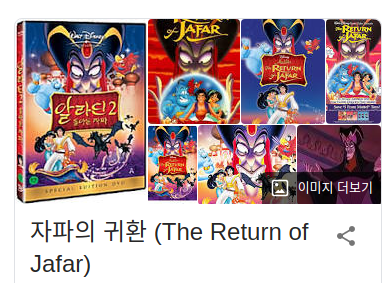
    - 유저에게 추천하기
        - 기존에 선호 목록에 '스타워즈 4 : 새로운 희망'에 있었고 추천 목록에 다른 스타워즈 시리즈들이 포함되어 있었다.
        - 목록 중에 '스타워즈 5 : 제국의 역습'이 있었고, 선호 목록에 있는 영화 데이터의 기여도를 확인할 결과, 스타워즈4의 기여도가 가장 높은 것을 확인할 수 있었다.